# Analysis of Public Comments Regarding the EPA's Revised Definition of "Waters of the United States" (WOTUS)

In early 2017, President Trump signed an Executive Order<sup>[1](#footnote1)</sup> requesting that agencies review a 2015 rule regarding the "Waters of the United States". The agencies, including the Environmental Protection Agency (EPA) and the Department of the Army, were instructed to rescind or replace the rule, in accordance with law.

The agencies have since conducted a reevaluation and revision of the definition of "Waters of the United States". Their proposed rule redefines the scope of waters federally regulated under the Clean Water Act (CWA). This rule was open for public comment until April 15, 2019.

This project applies Natural Language Processing techniques to analyze the content of the comments that are publicly available in docket EPA-HQ-OW-2018-0149 on the [regulations.gov web page](https://www.regulations.gov/docket?D=EPA-HQ-OW-2018-0149). For technical reasons, the dataset only includes ~8K out of the listed ~11K comments, which represent ones that were typed directly onto the site. The dataset excludes ~3K comments that were submitted in an attachment form. Out of the collected comments, a sample of 1200 were manually labeled to reflect support (1) or opposition (0) to the rule change. Labeling the data was necessary to perform sentiment analysis.

The goals of this project are to:

- Apply unsupervised learning algorithms to better understand the underlying structure of the comments - are there distinct topics or clusters, or is there too much language overlap for the model to find meaningful distinctions?
- Determine if the performance of sentiment analysis models meets thresholds to be able to label the remainder of the (un-labeled) comments

Notes:

<a name="footnote1">1</a>: Executive Order 13778, signed on February 28, 2017, titled "Restoring the Rule of Law, Federalism, and Economic Growth by Reviewing the 'Waters of the United States' Rule"

## Library Imports

In [17]:
# Standard imports
import re
import sys
import warnings
warnings.filterwarnings('ignore', 'DeprecationWarning') 

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [18]:
# Model and analysis imports
from scipy import linalg

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import LatentDirichletAllocation as LDA, TruncatedSVD, NMF, PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics
from sklearn.manifold import TSNE

import spacy

from wordcloud import WordCloud
import pyLDAvis.sklearn

In [19]:
# Un-comment and run cell to install spaCy and language model
# !conda install --yes --prefix {sys.prefix} spacy
# !{sys.executable} -m spacy download en_core_web_sm  # small language model
# !{sys.executable} -m spacy download en_core_web_lg  # large language model

In [20]:
# Un-comment and run cell to install pyLDAVis package
# !{sys.executable} -m pip install pyldavis

In [29]:
full_df = pd.read_pickle('./Data/full_labeled.pkl')

full_df.head()

,Document Title,Document ID,Posted Date,Received Date,Document SubType,Post Mark Date,Document Detail,Comment,Support_Rule_Change
0,Anonymous public comment,EPA-HQ-OW-2018-0149-6689,2019-04-29,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,I write to express my opposition to the Enviro...,0.0
1,Anonymous public comment,EPA-HQ-OW-2018-0149-6688,2019-04-29,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,I write to express my opposition to the Enviro...,0.0
2,Anonymous public comment,EPA-HQ-OW-2018-0149-7377,2019-05-01,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,Please abandon this proposed rollback of the 2...,0.0
3,Anonymous public comment,EPA-HQ-OW-2018-0149-6707,2019-04-29,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,"My husband and I have two wonderful daughters,...",0.0
4,Comment submitted by T. Dahlin,EPA-HQ-OW-2018-0149-7983,2019-05-01,2019-04-12,Public Comment,04/12/2019,https://www.regulations.gov/document?D=EPA-HQ-...,Please do not change the definitions within th...,0.0


In [57]:
# Segment comments and labels, drop duplicate comments, remove comment box artifacts
comments = full_df.loc[:, ['Comment', 'Support_Rule_Change']]
print(comments.loc[5993, 'Comment'])

comments.drop_duplicates(['Comment'], inplace=True)

comments['Comment'] = comments['Comment'].apply(lambda s: s.replace('PLEASE WRITE YOUR COMMENT HERE:', ''))
print(comments.loc[5993, 'Comment'])

PLEASE WRITE YOUR COMMENT HERE:  It is my wish and request that the Waters of the United States regulation be repealed. Regards, Thomas Moore
  It is my wish and request that the Waters of the United States regulation be repealed. Regards, Thomas Moore


In [58]:
comments.head()

,Comment,Support_Rule_Change
0,I write to express my opposition to the Enviro...,0.0
1,I write to express my opposition to the Enviro...,0.0
2,Please abandon this proposed rollback of the 2...,0.0
3,"My husband and I have two wonderful daughters,...",0.0
4,Please do not change the definitions within th...,0.0


In [59]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7986 entries, 0 to 8186
Data columns (total 2 columns):
Comment                7986 non-null object
Support_Rule_Change    1200 non-null float64
dtypes: float64(1), object(1)
memory usage: 507.2+ KB


In [62]:
# Fill unlabeled comments with -1
comments.fillna(value=-1, axis=1, inplace=True)
comments.tail()

,Comment,Support_Rule_Change
8182,I object to the proposed changes. We NEED all ...,0.0
8183,I am 39 years old and thanks to the hard work ...,0.0
8184,I pray that EPA leadership come to the underst...,-1.0
8185,clean water is one of the absolute necesseties...,-1.0
8186,The Clean Water Rule provides clear protection...,0.0


In [63]:
# Split ALL comments into training and test sets. The X_train set,
#    which has all training comments, will be used for unsupervised techniques
X = comments.drop('Support_Rule_Change', axis=1)
y = comments['Support_Rule_Change']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6388, 1) (1598, 1) (6388,) (1598,)


In [66]:
y != -1

0        True
1        True
2        True
3        True
4        True
        ...  
8182     True
8183     True
8184    False
8185    False
8186     True
Name: Support_Rule_Change, Length: 7986, dtype: bool

In [73]:
# Drop unlabeled comments from training and test sets to be
#    used in exploratory analysis and supervised learning
X_labeled_train = X_train[y_train != -1]
y_labeled_train = y_train[y_train != -1]

X_labeled_test = X_test[y_test != -1]
y_labeled_test = y_test[y_test != -1]

print(X_labeled_train.shape, y_labeled_train.shape, X_labeled_test.shape, y_labeled_test.shape)

(960, 1) (960,) (240, 1) (240,)


In [118]:
# Approximately 20% of the labeled comments were supportive of the rule change
y_labeled_train.value_counts()

0.0    765
1.0    195
Name: Support_Rule_Change, dtype: int64

In [74]:
# Helper function to show top words per topics
def show_topics(Vh, vocab_array, n_top_words=8):
    """
    Returns a list of the n_top_words from topic matrix Vh
    :param Vh: a topic (rows) by vocabulary (cols) orthonormal matrix
    :param vocab_array: a Numpy array of the vocabulary terms
        from the documents used in the analysis
    :param n_top_words: int of how many words to show by topic
    :return: list of strings with top words by topic in Vh
    
    >>>show_topics(my_Vh_matrix[:4], vocab)
    ['space launch satellite nasa commercial market satellites data',
     'god atheists atheism religious believe argument religion true',
     'nasa space lunar available mars probe moon edu',
     'atheists religious atheism god religion believe belief atheist']
    """
    top_words = lambda t: [vocab_array[i] for i in np.argsort(t)[:-n_top_words-1:-1]]
    topic_words = ([top_words(t) for t in Vh])
    return [' '.join(t) for t in topic_words]

In [75]:
# Helper function to plot most common words
def plot_most_common_words(count_data, count_vect, n=10):
    """
    :param count_data: data after running a CountVectorizer.fit_transform()
    :param count_vect: a CountVectorizer() instance
    :param n: int for how many top words to plot
    :return: None; plots a matplotlib.pyplot bar chart of top n words
    """
    words = count_vect.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts += t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:n]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words))

    plt.figure(figsize=(8, 6))
    plt.bar(x_pos, counts, align='center')
    plt.xticks(x_pos, words, rotation=-45) 
    plt.xlabel('Words')
    plt.ylabel('Counts')
    plt.title('{} Most Common Words'.format(n))
    plt.show()

## Create Term-Document Matrix

In [76]:
# Load language model
nlp = spacy.load('en_core_web_lg')

In [77]:
# Create custom tokenizer/lemmatizer
lemmatizer = spacy.lang.en.English()

def spacy_tokenizer(doc):
    """
    Applies spaCy's built-in tokenizer pipeline capabilities to
        to keep a lemmatized version of each token for alpha-
        numeric word's only (excludes punctuation and whitespace)
    """
    tokens = lemmatizer(doc)
    return([token.lemma_ for token in tokens if token.lemma_.isalnum()])

In [78]:
# Stop words
stop_words = list(nlp.Defaults.stop_words)
tokenized_stop_words = spacy_tokenizer(' '.join(stop_words))

In [88]:
# Create term-document matrix using a count vectorizer
count_vec = CountVectorizer(stop_words=tokenized_stop_words,
                            tokenizer=spacy_tokenizer,
                            max_df=0.90,
                            min_df=5)

count_data = count_vec.fit_transform(X_train['Comment'])
print(count_data.shape)

vocab = np.array(count_vec.get_feature_names())

(6388, 4144)


In [89]:
s = 200
print(vocab[s:s+100])

['admin' 'administer' 'administration' 'administrative' 'administrator'
 'admit' 'adopt' 'adoption' 'adult' 'advance' 'advantage' 'adverse'
 'adversely' 'advice' 'advise' 'advisory' 'advocacy' 'advocate'
 'aesthetic' 'affair' 'affect' 'afford' 'affordable' 'affront' 'afraid'
 'africa' 'afternoon' 'ag' 'age' 'agency' 'agencyadministrator'
 'agencyepa' 'agencys' 'agenda' 'agendum' 'agent' 'aggregate' 'aggressive'
 'ago' 'agree' 'agreement' 'agribusiness' 'agricultural' 'agriculture'
 'ahead' 'aid' 'aim' 'air' 'aka' 'akin' 'al' 'alabama' 'alan' 'alarm'
 'alaska' 'alexander' 'alga' 'algal' 'align' 'alike' 'alive' 'alleviate'
 'alliance' 'allison' 'allocate' 'allow' 'ally' 'almighty' 'alot' 'alter'
 'alteration' 'alternative' 'altogether' 'amanda' 'amaze' 'ambiguity'
 'ambiguous' 'amend' 'amendment' 'amenity' 'america' 'american'
 'americans' 'americas' 'amp' 'amphibian' 'ample' 'amy' 'analysis'
 'analyze' 'ancestor' 'ancient' 'anderson' 'andrew' 'angle' 'angler'
 'angry' 'animal' 'ann' 'an

In [96]:
# Create term-document matrix using TF-IDF vectorizer
tf_vec = TfidfVectorizer(**count_vec.get_params())

tf_data = tf_vec.fit_transform(X_train['Comment'])
print(tf_data.shape)

vocab_tf = np.array(tf_vec.get_feature_names())

/Users/heatherkusmierz/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:1817: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  UserWarning)


(6388, 4144)


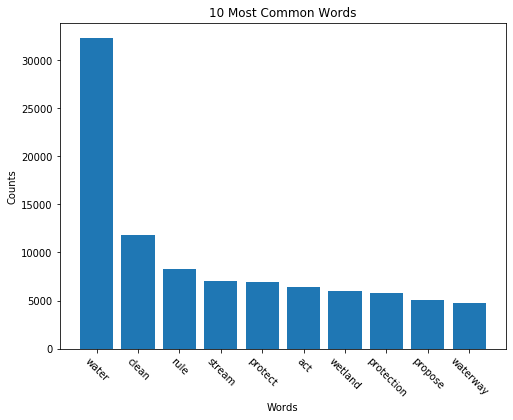

In [112]:
# Visualize 10 most common words
plot_most_common_words(count_data, count_vec)

## Topic Analysis

### Word Cloud - Full Training Set of Comments

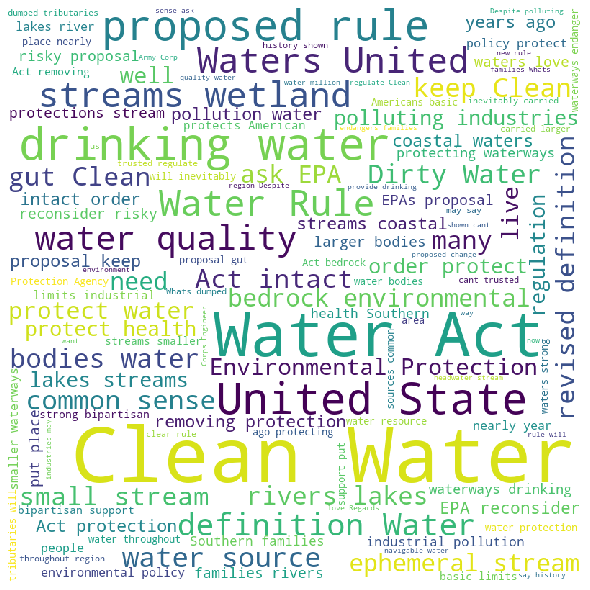

In [116]:
# Combine comments into one "text"
text_all = ' '.join(X_train['Comment'])

wordcloud_all = WordCloud(width = 800,
                          height = 800, 
                          background_color ='white',
                          min_font_size = 10).generate(text_all)

# Plot the word cloud
plt.figure(figsize = (8, 8), facecolor=None);
plt.imshow(wordcloud_all);
plt.axis("off");
plt.tight_layout(pad=0);
plt.savefig('./Figures/wordcloud_all.png');
plt.show();

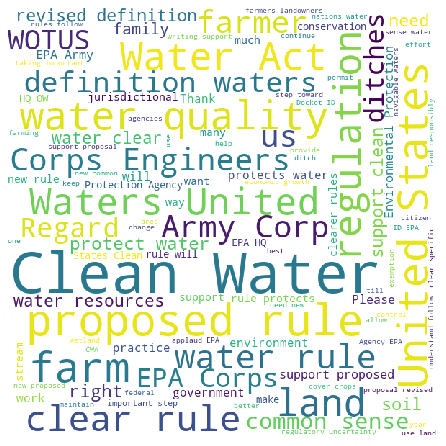

In [119]:
# Word cloud for SUPPORTIVE comments only
support_train = X_labeled_train[y_labeled_train == 1]

text_sup = ' '.join(support_train['Comment'])

wordcloud_sup = WordCloud(width = 600,
                          height = 600, 
                          background_color ='white',
                          min_font_size = 10).generate(text_sup)

# Plot the word cloud
plt.figure(figsize = (6, 6), facecolor=None);
plt.imshow(wordcloud_sup);
plt.axis("off");
plt.tight_layout(pad=0);
plt.savefig('./Figures/wordcloud_sup.png');
plt.show();

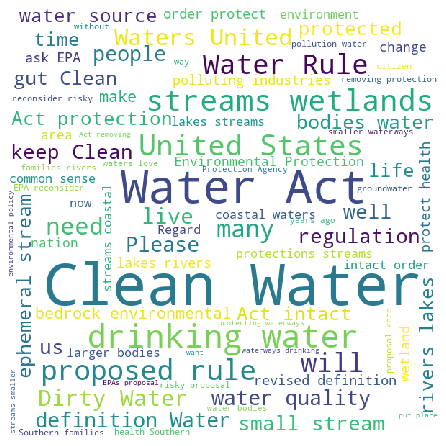

In [120]:
# Word cloud for OPPOSING comments only
oppose_train = X_labeled_train[y_labeled_train == 0]

text_opp = ' '.join(oppose_train['Comment'])

wordcloud_opp = WordCloud(width = 600,
                          height = 600, 
                          background_color ='white',
                          min_font_size = 10).generate(text_opp)

# Plot the word cloud
plt.figure(figsize = (6, 6), facecolor=None);
plt.imshow(wordcloud_opp);
plt.axis("off");
plt.tight_layout(pad=0);
plt.savefig('./Figures/wordcloud_opp.png');
plt.show();

### Singular Value Decomposition (SVD) Analysis

In [121]:
# Run SVD to create topic matrices
U, s, Vh = linalg.svd(count_data.todense(), full_matrices=False)
print(U.shape, s.shape, Vh.shape)

(6388, 4144) (4144,) (4144, 4144)


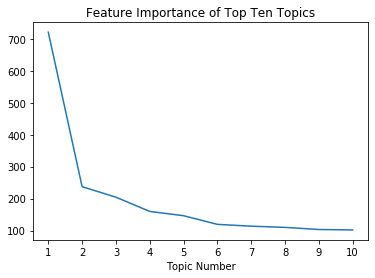

In [122]:
# Plot s to see where topic importance drops off
plt.plot(range(1, 11), s[:10]);
plt.xticks(range(1, 11));
plt.xlabel('Topic Number');
plt.title('Feature Importance of Top Ten Topics');

In [123]:
# Print top 10 topics
show_topics(Vh[:10], vocab)

['selfishness 0149please gracious communist rotational humble tyranny ward',
 'clean waterway act family proposal industry drink protect',
 'stream wetland downstream flow small headwater river fish',
 'water park protection quality wetland state change unite',
 'definition state waterway unite provide wotus tributary ephemeral',
 'waterway propose clean protection act community dirty polluter',
 'state definition downstream water unite community river dirty',
 'waterway new clear leave definition polluter farmer ephemeral',
 'epa community wetland family definition safeguard instead health',
 'propose water definition wotus park flow support body']

The first topic contains some curveballs (which call into question running SVD analysis directly like this), however the other topics seem to reasonably fit the core themes in the public comments.

### LDA

Latent Dirichlet Allocation (LDA) is a statistical model that finds the different mix of `n_components` topics that explain each comment. Comparing the perplexity metric of different numbers of topics is a quantitative way to help determine the appropriate number.

Per [Wikipedia's article on perplexity](https://en.wikipedia.org/wiki/Perplexity):

>In information theory, **perplexity** is a measurement of how well a probability distribution or probability model predicts a sample. It may be used to compare probability models. A low perplexity indicates the probability distribution is good at predicting the sample. 

LDA analysis had much higher perplexity scores (~10x higher) using the TF-IDF vectorizer vs. the standard count vectorizer, so all analysis below shows the count vectorizer only.

In [124]:
# Compare perplexity scores to find optimal number of topics
p = []

print('-'*30)
for n in range(2, 23, 2):
    mod = LDA(n_components=n,
              n_jobs=-1,
              random_state=42)
    mod.fit(count_data)
    p.append(mod.bound_)
    print('Number of Topics: {}'.format(n))
    print('Perplexity score: {0:,.0f}'.format(mod.bound_))
    print('-'*30)

------------------------------
Number of Topics: 2
Perplexity score: 581
------------------------------
Number of Topics: 4
Perplexity score: 524
------------------------------
Number of Topics: 6
Perplexity score: 503
------------------------------
Number of Topics: 8
Perplexity score: 480
------------------------------
Number of Topics: 10
Perplexity score: 474
------------------------------
Number of Topics: 12
Perplexity score: 474
------------------------------
Number of Topics: 14
Perplexity score: 465
------------------------------
Number of Topics: 16
Perplexity score: 461
------------------------------
Number of Topics: 18
Perplexity score: 464
------------------------------
Number of Topics: 20
Perplexity score: 462
------------------------------
Number of Topics: 22
Perplexity score: 459
------------------------------


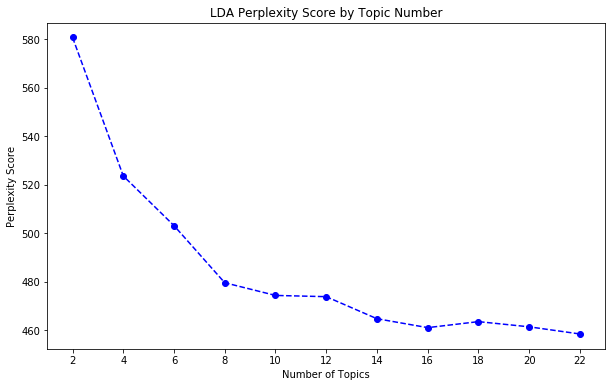

In [125]:
# Plot the perplexity scores
xtick = list(range(2, 23, 2))

plt.figure(figsize=(10, 6));
plt.xticks(xtick);
plt.plot(xtick, p, 'bo--');
plt.title('LDA Perplexity Score by Topic Number');
plt.ylabel('Perplexity Score');
plt.xlabel('Number of Topics');

The sharpest decline in perplexity score happens from two to eight topics, with a flattening out thereafter. As lower perplexity scores are better but increasing the number of topics will generally keep reducing the metric, this is a case where the "elbow" method can be applied. The chart indicates that around 8 topics is where the law of diminishing returns kicks in. The next step is to review the topics qualitatively to determine if they fit the dataset.

While there's overlap in the language of several topics (see below), there's one clear topic for supportive comments while the rest seem to highlight different reasons to oppose it. Given the ratio of around 20% supportive comments in the corpus, 1-2 topics would be representative.

In [126]:
# Analyze output using 8 topics
n_topics = 8

lda = LDA(n_components=n_topics,
          n_jobs=-1,
          random_state=42)

lda.fit(count_data)  # tfidf_data had much higher perplexity scores

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=8, n_jobs=-1,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [127]:
lda.components_.shape

(8, 4144)

In [128]:
print('Final perplexity score using {0} topics: {1:,.0f}'
      .format(n_topics, lda.bound_))

Final perplexity score using 8 topics: 480


In [129]:
print('Top words for each topic:\n')

show_topics(lda.components_, vocab, 10)

Top words for each topic:



['water stream wetland clean rule protect downstream propose river flow',
 'water waterway clean rule act propose wetland protection protect state',
 'water rule farmer clean clear support propose epa land farm',
 'water wetland state definition propose protection change stream unite rule',
 'water clean protect people need regulation environment life live right',
 'water wetland clean protection park stream quality waterway propose rule',
 'water clean act protect waterway river stream drink proposal family',
 'water clean rule act community protection dirty epa propose polluter']

In [131]:
# Check a test comment for most likely topic
comment_text = X_train.loc[187, 'Comment']
print(comment_text)

I support the revised clean water act rule. The fact is that farmers and ranchers take better care of our land, and water. We do not need to put unnecessary government restrictions on people who are already doing the right thing. Just so the government can be more controlling, and more money hungry with permits etc. I am a fifth generation Texas rancher, my land, and my water. My grandfather always said their are two things you can never get back land and water so we need to take care of it, and thats how ranchers and farmers think and treat it.


In [132]:
c = lda.transform(count_vec.transform([comment_text]))[0]
print(c, c.sum())
print('Most likely topic: {}'.format(np.argmax(c)))

[0.00284316 0.00284255 0.47862839 0.00284351 0.43714256 0.002844
 0.07000895 0.00284688] 1.0
Most likely topic: 2


In [52]:
# Visualize the Topics
# pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, count_data, count_vec, mds='tsne')
pyLDAvis.display(panel)

/Users/heatherkusmierz/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [170]:
pyLDAvis.save_html(panel, './index.html')

### NMF

In [45]:
# Create and fit an NMF model with count vectorizer
nmf = NMF(n_components=n_topics,
          random_state=42)

W1 = nmf.fit_transform(count_data)
H1 = nmf.components_

In [102]:
print(W1.shape)
print(H1.shape)

(6549, 8)
(8, 4141)


In [46]:
show_topics(H1, vocab, 10)

['water clean act protect need live life drink quality pollution',
 'rule propose epa farmer support farm land water corp clear',
 'stream wetland downstream rule flow propose small protect river headwater',
 'waterway protect stream proposal family act water industry drink river',
 'water clean rule community dirty epa polluter safeguard family waterway',
 'water state definition unite wetland protection change propose wotus revise',
 'waterway rule propose stream wetland new leave category ephemeral protection',
 'park protection water wetland quality stream propose small waterway country']

In [92]:
# Test cosine similarity - normalize features
norm_feats = normalize(W1)

In [93]:
# Find cosine similarity of test_comment to all others
sim_df = pd.DataFrame(norm_feats, index=X_train)
sim_df.head()

,0,1,2,3,4,5,6,7
Comment,,,,,,,,
"We da people have da power to send u to Washington with our votes,should be ashamed to take our property rights,may this world find da Lord's mercy especially TV those that abuse da system...!! Regards, William Perez",0.000000,0.156078,0.00000,0.536618,0.000000,0.829265,0.000000,0.000000
"April 15, 2019U.S. Environmental Protection Agency EPA Docket Center Office of Water DocketMail Code 28221T 1200 Pennsylvania Avenue, NWWashington, DC 20460RE:Docket ID No. EPA-HQ-OW-2018-0149To Whom it May Concern:I am a farmer in Champaign county, Illinois. I am writing to submit comments to the United States Environmental Protection Agency (EPA) and the United States Army Corps of Engineers (Corps) in support of the proposal for the revised definition of Waters of the United States under the Clean Water Act.It is time for clear rules that protect both the nations water bodies and farmers ability to produce food, fiber and fuel. This proposed rule would have the ability to end years of uncertainty over where the jurisdiction of EPA and the Corps begins and ends. We need a new common-sense water rule that protects water quality and gives me clear rules I can follow. This new proposed rule would ensure that I dont need a team of lawyers or consultants to tell me what is, and what is not, regulated by EPA and the Corps. The 2015 rule, by contrast, provided none of the clarity and certainty it promised. Instead, the rules gave EPA and the Corps virtually unlimited authority to regulate, at their discretion, navigable waters. My wife and I are fourth generation farmers who are striving to ensure our family farm will be sustainable for generations to come. We are following in the footsteps of previous generations who have worked to implement practices to maintain the quality of our land. We have had and continue to have acres in the conservation reserve program as well as utilizing filter strips, no till/minimal till farming, and working with our suppliers to apply fertilizers according to the 4Rs. Our family is also active with local drainage districts and the farm bureau to make sure we can help in areas off our own family farm. We are continually reviewing our practices in order to make sure we can protect our soil and water quality so that future generations can continue to prosper from the land.I strongly welcome the proposed rule as it protects water resources, respects the law and provides greater clarity so the agencies, farmers and the public can identify regulated federal waterways. Sincerely, Michael Briggs504 Landen Ln Fisher, IL 61843",0.232243,0.959336,0.00000,0.090539,0.000000,0.126524,0.000000,0.039140
"I Strongly Oppose EPAs Revised Definition of Waters of the United States I am writing because I am opposed to EPAs revised definition of Waters of the United States (WOTUS), as well as the specific exclusions set forth in the proposed rule. This revised definition attempts to roll back the scope of the Clean Water Act and limit protections for wetlands and waterways that drain into the Salish Sea. Our waterways and wetlands, and the marine ecosystems these waters drain into, such as our Salish Sea, are invaluable assets to our communitiesthey provide us with sources of safe and affordable drinking water, as well as recreational areas, jobs, and wildlife habitat. We should be strengthening protections for clean water; not rolling them back. The Clean Water Act was created in recognition of the fact that water flows downstream. Small creeks and wetlands flow into the sea, as well as into our major rivers and lakes. In order to protect the waters of the United States, as directed by Congress, all waterways must receive the protections of the Clean Water Act. If an individual or corporation is allowed to pollute or destroy a stream, wetland, river, or lake, the impacts will inevitably be systemic. This proposed rule would remove protections for more than half of our nations wetlands. There is strong sc

In [150]:
# Save a test comment
comment_text = X_train.loc[187]
print(comment_text, '\n----------\n')

test_comment = sim_df.loc[comment_text]
print(test_comment)

I support the revised clean water act rule. The fact is that farmers and ranchers take better care of our land, and water. We do not need to put unnecessary government restrictions on people who are already doing the right thing. Just so the government can be more controlling, and more money hungry with permits etc. I am a fifth generation Texas rancher, my land, and my water. My grandfather always said their are two things you can never get back land and water so we need to take care of it, and thats how ranchers and farmers think and treat it. 
----------

0    0.808347
1    0.588706
2    0.000000
3    0.000000
4    0.000000
5    0.000000
6    0.000000
7    0.000000
Name: I support the revised clean water act rule. The fact is that farmers and ranchers take better care of our land, and water. We do not need to put unnecessary government restrictions on people who are already doing the right thing. Just so the government can be more controlling, and more money hungry with permits etc.

In [95]:
similarities = sim_df.dot(test_comment)
print(similarities.nlargest())

Comment
I support the revised clean water act rule. The fact is that farmers and ranchers take better care of our land, and water. We do not need to put unnecessary government restrictions on people who are already doing the right thing. Just so the government can be more controlling, and more money hungry with permits etc. I am a fifth generation Texas rancher, my land, and my water. My grandfather always said their are two things you can never get back land and water so we need to take care of it, and thats how ranchers and farmers think and treat it.    1.000000
I am writing to support the proposal for the revised definition of waters of the United States, under the Clean Water Act.  Farmers care about clean water but also need clear rules.As a farmer, I should be able to look at the land and know what is and what is not federally regulated under the Clean Water Act. The proposed rule is better for farmers and landowners to understand and to follow.                                  

In [118]:
# Test comment 2
comm_2_text = X_train.loc[190]
print(comm_2_text, '\n----------\n')

test_2 = sim_df.loc[comm_2_text]
print(test_2)

Save the Clean Water Act! Don't eliminate water protections for our streams, rivers, lakes, and wetlands, which would result in a profound weakening of the requirements that keep our waters safe for recreation, wildlife, and drinking water for millions of Americans. 
----------

0    0.847896
1    0.000000
2    0.299145
3    0.120186
4    0.000000
5    0.128611
6    0.000000
7    0.400748
Name: Save the Clean Water Act! Don't eliminate water protections for our streams, rivers, lakes, and wetlands, which would result in a profound weakening of the requirements that keep our waters safe for recreation, wildlife, and drinking water for millions of Americans., dtype: float64


In [98]:
similarities_2 = sim_df.dot(test_2)
print(similarities_2.nlargest())

Comment
Save the Clean Water Act! Don't eliminate water protections for our streams, rivers, lakes, and wetlands, which would result in a profound weakening of the requirements that keep our waters safe for recreation, wildlife, and drinking water for millions of Americans.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [164]:
_text = "I'm a farmer and I support the proposed rule change. I think it clarifies the regulatory landscape and makes it easier to run my business."
_testcomm = pd.Series(_text)
_count = count_vec.transform(_testcomm)

_W1 = nmf.transform(_count)
_sim_df = pd.DataFrame(_W1, index=_testcomm)
print(_sim_df.loc[_text])

_similarities = sim_df.dot(_sim_df.loc[_text])
print(_similarities.nlargest())

0    0.000000
1    0.068082
2    0.000077
3    0.000000
4    0.000000
5    0.000000
6    0.017889
7    0.000000
Name: I'm a farmer and I support the proposed rule change. I think it clarifies the regulatory landscape and makes it easier to run my business., dtype: float64
Comment
I really hope this is a joke but I woilw like some more information on the subject... Regards, Bert earhardt                                                                                                                                                                                                                                                  0.070321
I am TOTALLY IN FAVOR of the revised rules for WOTUS.  The rule proposed by Obama ignores the fact that agriculture is the MOST IMPORTANT industry of all - agriculture feeds us!  PLUS Obama's rule violates the right to PRIVATE PROPERTY and is a violation of the BILL OF RIGHTS as it confiscates private property without just compensation!            0.070122
T

In [47]:
# Create and fit an NMF model with TF-IDF vectorizer
nmf_tf = NMF(n_components=n_topics,
             random_state=42)

W1_tf = nmf_tf.fit_transform(tf_data)
H1_tf = nmf_tf.components_

In [48]:
show_topics(H1_tf, vocab)

['wetland stream downstream water flow propose headwater rule',
 'water protect act waterway clean family proposal region',
 'water clean community safeguard dirty instead polluter rule',
 'rule farmer water clear support land new farm',
 'overall protection loss concern harm rappahannock water impact',
 'water unite state dangerous dirty definition revise people',
 'park water clean protection wetland quality country roll',
 'blanket arroyos handout cinegas acequias creek disregard connectivity']

## Clustering Analysis

In [49]:
# Create various options for the word vectorizer
# n_feats = 14000
use_bigrams = True

if use_bigrams:
    b = 2
else:
    b = 1

# Comment out all vectorizer defs except the one to use
# Simple count vectorizer
vectorizer = CountVectorizer(stop_words=tokenized_stop_words,
                             tokenizer=spacy_tokenizer,
                             max_df=0.9
                             ngram_range=(1, b))
chart_title = 'Count'

# Hashing vectorizer using L2 norm
# vectorizer = HashingVectorizer(stop_words=tokenized_stop_words,
#                                tokenizer=spacy_tokenizer,
#                                n_features=n_feats,
#                                ngram_range=(1, b),
#                                norm='l2')

# chart_title = 'HashL2'

# Hashing vectorizer normalized using TF-IDF
# hashy = HashingVectorizer(n_features=n_feats,
#                            stop_words='english',
#                            ngram_range=(1, b),
#                            norm=None)
# 
# chart_title = 'HashTFIDF'

# vectorizer = make_pipeline(hashy, TfidfTransformer())

# TF-IDF vectorizer
# vectorizer = TfidfVectorizer(max_features=n_feats,
#                              ngram_range=(1, b),
#                              stop_words='english')
# 
# chart_title = 'TFIDF'

In [50]:
# Transformed features
X_data = vectorizer.fit_transform(X_train)
print(X_data.shape)

(6549, 169469)


In [51]:
# Create and fit a KMeans algorithm
kmeans = KMeans(n_clusters=2,
                max_iter=100,
                n_init=1,
                n_jobs=-1)

kmeans.fit(X_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=2, n_init=1, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [52]:
# Examine metrics for KMeans
# print(kmeans.labels_)
print('Inertia: {0: .3f}'.format(kmeans.inertia_))
print('Silhouette Coefficient: {0:.3f}'.format(
      metrics.silhouette_score(X_data, kmeans.labels_, sample_size=1000)))

Inertia:  1249972.812
Silhouette Coefficient: 0.262


In [53]:
# Compare metrics of different number of clusters
n_clusters = list(range(2, 13))
inertias = []
silhouettes = []

for n in n_clusters:
    model = KMeans(n_clusters=n,
                   max_iter=100,
                   n_init=1,
                   n_jobs=-1)
    model.fit(X_data)
    inertias.append(model.inertia_)
    silhouettes.append(metrics.silhouette_score(X_data, model.labels_, sample_size=1000))

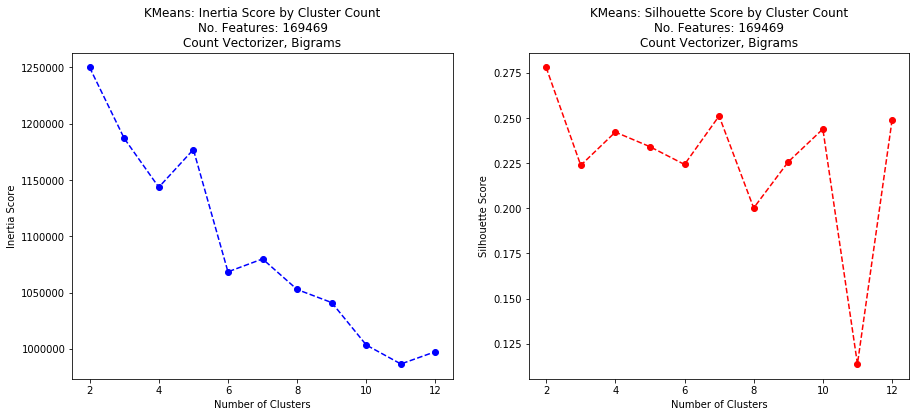

In [158]:
# Plot scores by cluster
plt.subplots(1, 2, figsize=(15, 6))

# Cluster-inertia plot
plt.subplot(1, 2, 1);
plt.plot(n_clusters, inertias, 'bo--');
plt.xlabel('Number of Clusters');
plt.ylabel('Inertia Score');
plt.title('KMeans: Inertia Score by Cluster Count\n'
          'No. Features: {}\n'
          '{} Vectorizer{}'
          .format(X_data.shape[1], chart_title, ', Bigrams' if use_bigrams else ''));

# Cluster-silhouette score plot
plt.subplot(1, 2, 2);
plt.plot(n_clusters, silhouettes, 'ro--');
plt.xlabel('Number of Clusters');
plt.ylabel('Silhouette Score');
plt.title('KMeans: Silhouette Score by Cluster Count\n'
          'No. Features: {}\n'
          '{} Vectorizer{}'
          .format(X_data.shape[1], chart_title, ', Bigrams' if use_bigrams else ''));

plt.savefig('./Figures/KMeans_{}{}_Inertia-Silhouette.png'
            .format(chart_title, 'Bigrams' if use_bigrams else ''));

**Inertia** calculates the sum of the squared distances between data points and their nearest cluster. Low overall values of inertia are generally better, but it will naturally favor having more clusters.

**Silhouette score** uses two scores to find the mean distance between each observation and all others - both in the same cluster and then in the nearest cluster. Values range from -1 to 1, where a score of 1 indicates the point is close to others in the same cluster, but far away from the next cluster over. A score near -1 indicates the point is not near ones in its cluster but close to the next nearest cluster. And a score of 0 indicates overlapping clusters, where an observation is close to the decision boundary. A score closest to 1 is ideal, as that indicates tight, highly separable clusters.

The KMeans algorithm was run with four different pre-processing applications, then using unigrams only vs. also including bigrams. Including bigrams did not generally improve the metrics, therefore the charts weren't included below.

1) **Count Vectorizer**

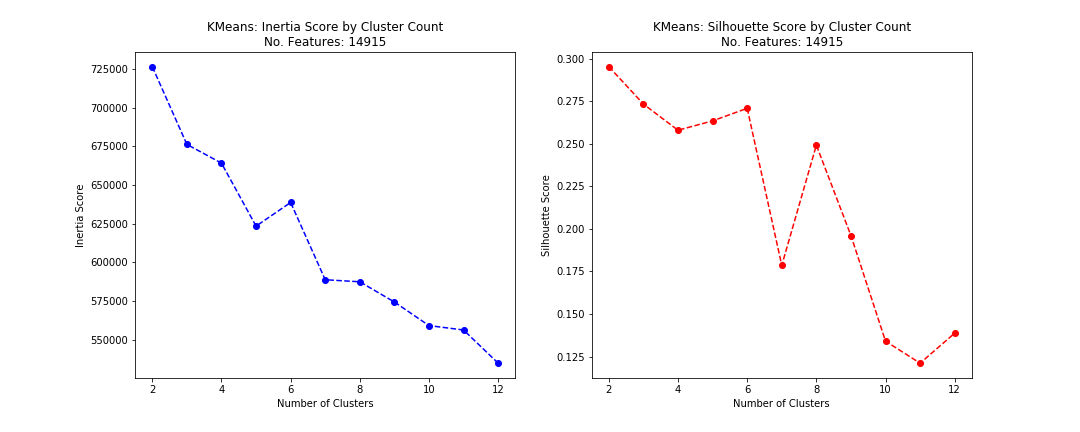

The count vectorizer plots had inertia values that were a factor of over a hundred times higher than all the others, but managed the highest overall silhouette scores, with the peak value over 0.3 at two clusters. Adding bigrams increased the inertia values to over 1,250,000 and had a slight reduction in silhouette scores, so overall not an improvement.

2) **Hashing Vectorizer with L2 Norm**

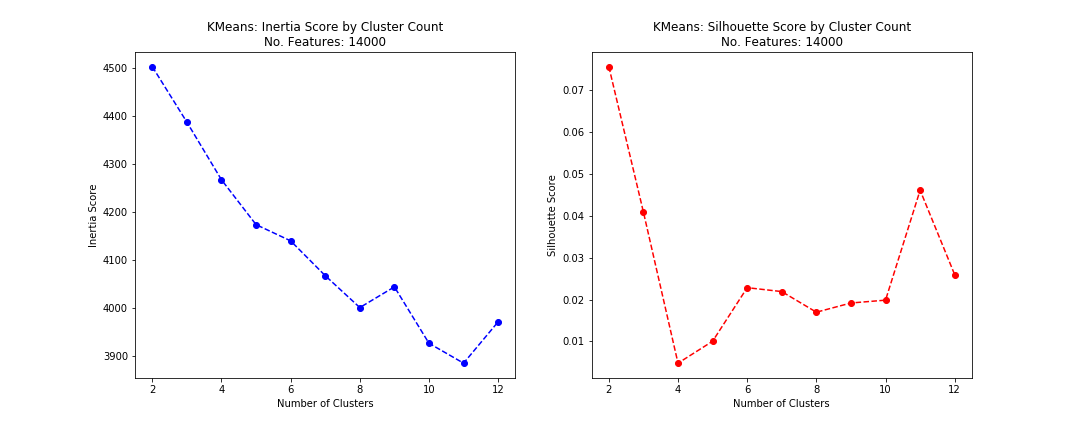

This method had the lowest overall inertia values and second highest overall silhouette scores.

While the inertia score is the highest for two clusters (as expected), the silhouette score favors two clusters as being the optimal number. This aligns with the nature of the dataset having sets of comments from two distinct groups: those that support the rule change and those that oppose it.

There are two trends worth pointing out in these chart. One is the jump from eight clusters to nine - there's little improvement to the inertia calculation, but almost a 4x improvement of silhouette score. This is repeated to a lesser degree in the move from ten to eleven clusters. The other is the move from four to five clusters - there's a steady decrease in inertia but an almost 2x increase in the silhouette score.

3) **Hashing Vectorizer Normalized using TF-IDF**

![Inertia and silhouette scores by cluster]()

This analysis shows a completely different story, indicating that ten clusters is optimal. That cluster count has both the minimum inertia value as well as the peak silhouette score. However, the overall inertia and silhouette values are worse than the previous analysis using an L2 norm. The inertia scores are all higher, and the best silhouette score is still below the two-cluster score from before.

4) **TF-IDF Vectorizer**

![Inertia and silhouette scores by cluster]()

Not surprisingly, this analysis is more similar to the hashing vectorizer with TF-IDF normalization than the hashing vectorizer with an L2 norm. The overall score values are in line with where they fell out in the other TF-IDF-based analysis. Nine seems to be a good choice of clusters, with its dip in inertia and jump in silhouette scores (especially off the trough at eight clusters). However, the silhouette scores continue to climb at the limit of twelve clusters, indicating there could be better performance.

In [55]:
# Print comments from cluster 0
cluster_0 = X_train[kmeans.labels_ == 0]

for row in cluster_0.head(20):
    print(row)
    print('\n----------\n')

We da people have da power to send u to Washington with our votes,should be ashamed to take our property rights,may this world find da Lord's mercy especially TV those that abuse da system...!! Regards, William Perez

----------

I am vehemently opposed to the continued (and potential permanent) suspension of the Clean Water Rule.  Water is our most important natural resources.  If we relax our restrictions, we risk additional contamination to our drinking water due to run-off and other problems.  In addition, we need to preserve our non-navigable waterways such as peatland in Wisconsin and surrounding areas, as these result in carbon trapping, further helping to mitigate climate change.  For these and many other scientific reasons, I would ask that the situation be reconsidered.  Please reinstitute the Clean Water Rule.  Thank you for your consideration.

----------

PLEASE WRITE YOUR COMMENT HERE: Fund the Border wall and protect Americans with the border wall, sad that 4,000 America

In [56]:
# Print comments from cluster 1
cluster_1 = X_train[kmeans.labels_ == 1]

for row in cluster_1.head(20):
    print(row)
    print('\n----------\n')

April 15, 2019U.S. Environmental Protection Agency EPA Docket Center Office of Water DocketMail Code 28221T 1200 Pennsylvania Avenue, NWWashington, DC 20460RE:Docket ID No. EPA-HQ-OW-2018-0149To Whom it May Concern:I am a farmer in Champaign county, Illinois. I am writing to submit comments to the United States Environmental Protection Agency (EPA) and the United States Army Corps of Engineers (Corps) in support of the proposal for the revised definition of Waters of the United States under the Clean Water Act.It is time for clear rules that protect both the nations water bodies and farmers ability to produce food, fiber and fuel. This proposed rule would have the ability to end years of uncertainty over where the jurisdiction of EPA and the Corps begins and ends. We need a new common-sense water rule that protects water quality and gives me clear rules I can follow. This new proposed rule would ensure that I dont need a team of lawyers or consultants to tell me what is, and what is no

In [57]:
# Reduce dimensions with PCA
pca = PCA(n_components=50)
components = pca.fit_transform(X_data.todense())
print(pca.explained_variance_ratio_)
sum(pca.explained_variance_ratio_)

[0.18907357 0.06166053 0.03903373 0.02959861 0.02445684 0.01656873
 0.0156257  0.01507728 0.01403607 0.01064842 0.00992414 0.00930263
 0.00823692 0.00744712 0.00696163 0.00666446 0.00576835 0.00552284
 0.00506158 0.00493378 0.00473025 0.00452606 0.00429783 0.00401386
 0.00386101 0.0036893  0.00343043 0.00330445 0.00322912 0.00311173
 0.00301786 0.00288923 0.00274947 0.00269701 0.00256    0.00247283
 0.00233564 0.00229267 0.00225656 0.00219624 0.00212259 0.00211431
 0.00202227 0.00195433 0.00192747 0.00192244 0.00186941 0.00182526
 0.00179185 0.00173657]


0.5685509857389042

In [58]:
components.shape

(6549, 50)

In [59]:
# Re-create DF with labeled clusters
col_names = ['pca_{}'.format(i + 1) for i in range(pca.n_components_)]

pca_df = pd.DataFrame(components, columns=col_names, index=X_train.index)
pca_df['cluster'] = kmeans.labels_

pca_df.head()

,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,...,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39,pca_40,pca_41,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49,pca_50,cluster
3783,-6.988242,-0.078455,0.600188,0.350077,-0.039059,-0.100095,0.314971,-0.132955,0.193868,0.043870,0.154778,0.027457,0.156872,-0.104471,-0.233159,0.009795,-0.114135,0.084342,0.101451,0.035700,-0.061286,0.218991,-0.001577,0.224883,-0.041556,...,0.110649,0.153337,0.192093,0.068443,-0.023449,0.019574,0.122048,-0.068060,-0.201616,-0.011493,-0.310805,0.109872,-0.259468,-0.331251,0.202644,0.081793,-0.028758,-0.069757,0.212003,-0.042302,-0.302175,0.242804,-0.087718,0.144952,0
2110,6.462078,-8.001465,-10.175498,3.889757,-4.805961,6.598756,-2.579382,2.026346,-0.293808,10.941545,-3.557833,1.036633,-0.583799,-2.184234,-0.463617,-1.509382,-3.035718,-0.414488,1.181608,0.633174,-0.761856,-0.729554,-0.909473,-0.597382,-0.603941,...,0.213470,-0.160759,-0.983531,-0.399898,-0.908321,-0.131187,0.070034,0.851135,0.723350,0.123478,-0.266052,0.764590,0.367183,-0.461188,-0.074101,0.039092,-0.182539,-0.063821,0.800885,0.453692,0.059977,0.507568,0.376914,-0.070898,1
2002,22.999196,-2.806202,-0.007386,-1.362399,3.631840,-6.742322,2.653941,-2.355586,-6.258460,-3.510572,-7.434910,2.473976,4.133889,-5.771495,-0.244962,-0.724860,0.951102,-0.327751,6.984431,-1.107209,5.001807,-2.902196,-4.005446,-7.154471,-6.506459,...,2.515759,2.076668,1.495568,-5.093924,1.304104,2.037681,-0.593241,-2.080477,-2.121233,-1.436920,0.832870,-1.911015,1.821039,-1.769203,0.830039,2.588724,-0.451737,-0.842425,2.051593,-1.006513,-0.409824,0.470390,0.189208,-1.542436,1
3047,9.265578,10.887132,-1.702740,3.774142,0.497497,-1.281987,0.280988,-0.437513,0.751648,1.271604,0.093942,1.691504,1.875712,-0.800702,-0.454775,-0.954100,0.623204,0.563777,-0.344089,-0.253963,0.798611,0.869094,0.375097,-0.261906,-0.070279,...,0.458399,-0.642559,0.155177,0.465677,1.033349,-0.196134,0.158975,-0.406901,-0.496486,0.347800,-0.397277,0.202857,-1.032860,0.409442,0.231945,-0.006079,-0.938441,1.385878,0.239827,0.126827,-0.756501,0.795273,0.725711,0.330611,1
418,-2.275249,-0.315430,-0.279999,-1.289857,-0.402762,0.411919,0.051670,0.337858,-0.286024,-0.712471,0.397320,-0.912491,0.713092,0.395776,0.657970,0.037492,-0.526134,0.468666,-0.151019,-0.183802,-0.857933,-0.015376,-0.579456,-0.528356,-0.171127,...,-0.289701,0.241652,-0.058237,0.150081,0.368532,-0.771357,-0.588163,-0.254433,-0.063201,0.029593,-0.144006,-0.357068,0.660576,0.892020,0.055577,0.245766,0.293930,-0.689665,0.315957,-0.097251,0.273067,0.248618,-0.120362,-0.148678,0


In [60]:
# Read in labeled comment sample
labels = pd.read_excel('./Data/comments_labeled.xlsx',
                       header=0,
                       index_col=0,
                       usecols=[0, 2])

labels.dropna(inplace=True)  # only keep labeled samples
labels.shape

(202, 1)

In [61]:
samples = pd.merge(labels, pca_df[['pca_1', 'pca_2']],
                   left_index=True,
                   right_index=True)

samples.tail(10)

,Support_Rule_Change,pca_1,pca_2
193,0.0,-1.780858,1.021935
194,0.0,5.606051,2.048253
195,1.0,-6.315131,-0.122651
196,0.0,-5.468302,-0.555857
197,1.0,-1.880429,-0.100075
200,0.0,-2.376351,2.792487
201,0.0,-2.621916,-2.668467
202,0.0,-3.562538,0.408654
203,0.0,-3.232154,0.679567
204,0.0,1.049201,0.223553


In [62]:
samples.shape

(157, 3)

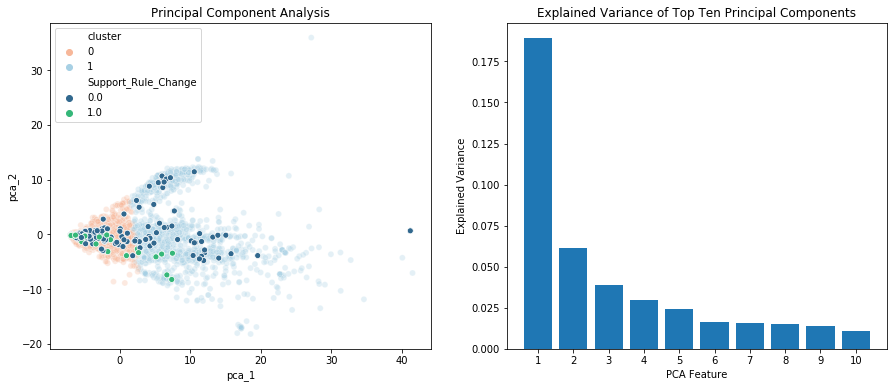

In [63]:
# Plot first two principal components and explained variance
plt.subplots(1, 2, figsize=(15, 6));
plt.subplot(1, 2, 1);
sns.scatterplot(x='pca_1', y='pca_2', data=pca_df, hue='cluster', alpha=0.3, palette='RdBu');
sns.scatterplot(x='pca_1', y='pca_2', data=samples, hue='Support_Rule_Change', palette='viridis')
plt.title('Principal Component Analysis');

feats = range(1, 11)
plt.subplot(1, 2, 2);
plt.bar(feats, pca.explained_variance_ratio_[:10]);
plt.xticks(feats);
plt.xlabel('PCA Feature');
plt.ylabel('Explained Variance');
plt.title('Explained Variance of Top Ten Principal Components');

plt.savefig('./Figures/PCA_{}{}Lemma.png'.format(chart_title, 'Bigrams' if use_bigrams else ''));

In [64]:
# TSNE cluster visualization
tsne = TSNE(n_components=2, perplexity=30)
tsne_res = tsne.fit_transform(X_data)

In [65]:
tsne_res.shape

(6549, 2)

In [66]:
# Re-create DF with TSNE results
tsne_df = pd.DataFrame(tsne_res, columns=['tsne_1', 'tsne_2'], index=X_train.index)
tsne_df['cluster'] = kmeans.labels_

tsne_df.head()

,tsne_1,tsne_2,cluster
3783,2.090433,32.460896,0
2110,53.777203,-4.799178,1
2002,-32.537228,-19.469563,1
3047,17.175196,-40.237095,1
418,11.572308,8.600972,0


In [67]:
# Create TSNE sample DF
tsne_samples = pd.merge(labels, tsne_df[['tsne_1', 'tsne_2']],
                        left_index=True,
                        right_index=True)

tsne_samples.tail(10)

,Support_Rule_Change,tsne_1,tsne_2
193,0.0,-0.623096,-4.700883
194,0.0,12.200483,-25.251297
195,1.0,-15.212007,29.088776
196,0.0,-3.692414,-61.038021
197,1.0,0.332374,-3.210941
200,0.0,9.080447,-18.058332
201,0.0,-9.154532,26.201662
202,0.0,4.708173,7.525336
203,0.0,3.286972,-4.547688
204,0.0,-4.220626,-8.533299


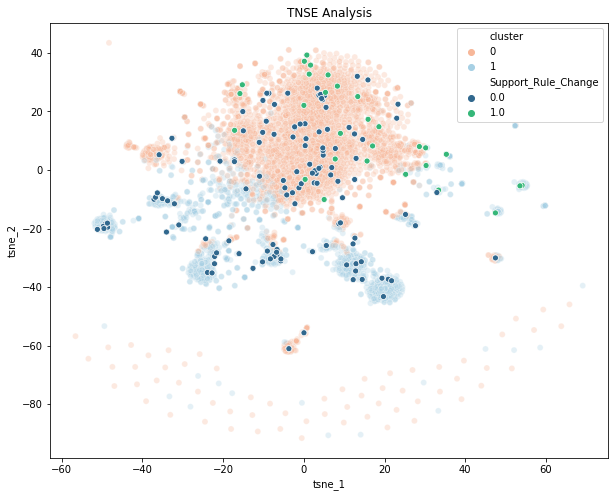

In [68]:
# Plot the TSNE results
plt.figure(figsize=(10, 8));
sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_df, hue='cluster', alpha=0.3, palette='RdBu');
sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_samples, hue='Support_Rule_Change', palette='viridis');
plt.title('TNSE Analysis');
plt.savefig('./Figures/TSNE_{}{}Lemma.png'.format(chart_title, 'Bigrams' if use_bigrams else ''))